# Predicción precipitaciones y temperatura

In [1]:
!pip3 install geopandas fiona shapely

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import json
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
df_lluvias=pd.read_csv('precipitacionsbarcelonadesde1786_format_long.csv')
df_temperaturas=pd.read_csv('temperaturesbarcelonadesde1780_format_long.csv')

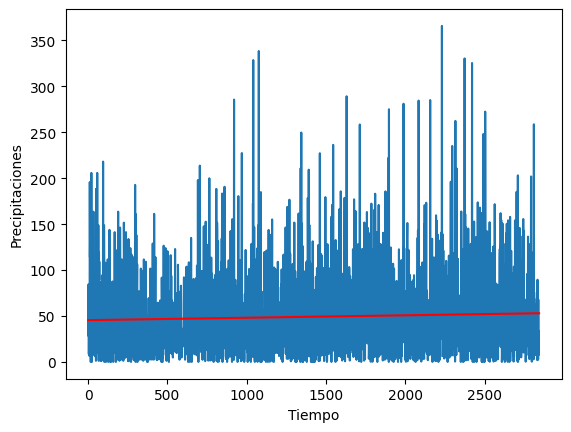

In [4]:
model = np.poly1d(np.polyfit(np.arange(len(df_lluvias)), 
                             df_lluvias['Precipitacions'], 1
                             ))
  
polyline = np.linspace(0, len(df_lluvias)) 
plt.plot(np.arange(len(df_lluvias)),df_lluvias['Precipitacions']) 
plt.plot(polyline, model(polyline),color='red') 
plt.ylabel('Precipitaciones')
plt.xlabel('Tiempo')
plt.show() 

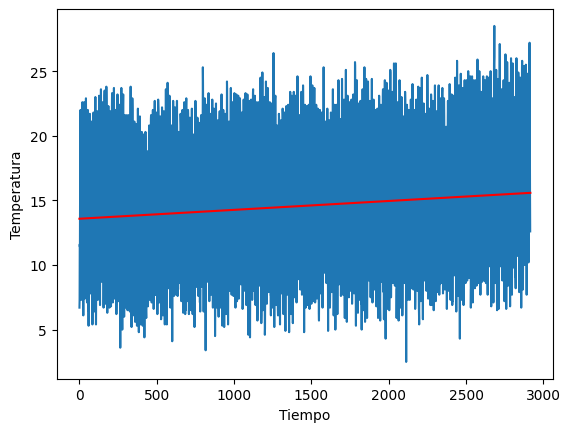

In [5]:
model = np.poly1d(np.polyfit(np.arange(len(df_temperaturas)), 
                             df_temperaturas['Temperatura'], 1
                             ))

polyline = np.linspace(0, len(df_temperaturas)) 
plt.plot(np.arange(len(df_temperaturas)),df_temperaturas['Temperatura']) 
plt.plot(polyline, model(polyline),color='red')
plt.ylabel('Temperatura')
plt.xlabel('Tiempo')
plt.show()

Los datasets empiezan en 1786 y 1780 respectivamente, observándose una tendencia estable en cuanto a las precipitaciones y una tendencia ascendente en cuanto a la temperatura. De cara a crear un modelo predictivo para ambas variables, vamos a centrarnos en la historia más reciente, los 30 últimos años. Utilizando la información de este periodo, entrenaremos un modelo con la evolución de estas variables a lo largo de 25 años. Ventana que progresivamente irá avanzando para validar el modelo con 4 conjuntos de validación (cada uno de ellos de un periodo de un año) y finalmente dar una puntuación del rendimiento del modelo (usando métrica RMSE) para el conjunto de prueba (último año).

In [6]:
#Tomamos los ultimos 30 años de lluvia
df_lluvias_30=df_lluvias.loc[df_lluvias['Any']>1992].copy()
df_lluvias_30.reset_index(inplace=True, drop=True)
sscaler=StandardScaler()
df_lluvias_30_stand=df_lluvias_30.copy()
df_lluvias_30_stand['Precipitacions']=sscaler.fit_transform(df_lluvias_30['Precipitacions'].to_numpy().reshape(-1,1))
df_lluvias_30_stand

,Any,Mes,Desc_Mes,Precipitacions
0,1993,1,Gener,-1.040841
1,1993,2,Febrer,-0.512178
2,1993,3,Març,0.977311
3,1993,4,Abril,1.025562
4,1993,5,Maig,-0.516373
...,...,...,...,...
355,2022,8,Agost,0.383613
356,2022,9,Setembre,-0.766020
357,2022,10,Octubre,-0.803782
358,2022,11,Novembre,-0.881403


In [7]:
#Tomamos los ultimos 30 años de temperatura
df_temperaturas_30=df_temperaturas.loc[df_temperaturas['Any']>1992].copy()
df_temperaturas_30.reset_index(inplace=True, drop=True)
df_temperaturas_30_stand=df_temperaturas_30.copy()
df_temperaturas_30_stand['Temperatura']=sscaler.fit_transform(df_temperaturas_30['Temperatura'].to_numpy().reshape(-1,1))
df_temperaturas_30_stand

,Any,Mes,Desc_Mes,Temperatura
0,1993,1,Gener,-1.231615
1,1993,2,Febrer,-1.371175
2,1993,3,Març,-1.022275
3,1993,4,Abril,-0.568706
4,1993,5,Maig,0.163983
...,...,...,...,...
355,2022,8,Agost,1.943369
356,2022,9,Setembre,1.123456
357,2022,10,Octubre,0.809447
358,2022,11,Novembre,-0.150027


In [8]:
def make_prediction(df):
    for i in range(5):
        data_years=df.iloc[i*12:12*25+i*12,-1].to_numpy()
        if i==0:
            X=data_years[:-12].reshape(1,-1)
            y=data_years[-12:].reshape(1,-1)
        else:
            X=np.concatenate((X,data_years[:-12].reshape(1,-1)),axis=0)
            y=np.concatenate((y,data_years[-12:].reshape(1,-1)),axis=0)
    
    X_train=X[:-1,:]
    y_train=y[:-1,:]
    X_test=X[-1,:].reshape(1,-1)
    y_test=y[-1,:].reshape(1,-1)

    estimator = LGBMRegressor()
    
    regr = MultiOutputRegressor(estimator = estimator)
    regr = regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)

    test_score=mean_squared_error(y_test, y_pred, squared=False)

    return np.round(test_score,3)

In [9]:
test_score_temperatura=make_prediction(df_temperaturas_30_stand)
test_score_lluvia=make_prediction(df_lluvias_30_stand)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] Start training from score -1.209809
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

In [10]:
print('RMSE Test para Temperaturas:')
print(test_score_temperatura)
print('RMSE Test para Precipitaciones:')
print(test_score_lluvia)

RMSE Test para Temperaturas:
0.162
RMSE Test para Precipitaciones:
0.664


## Conclusiones de los modelos predicivos

Como podemos observar en los valores de RMSE de los modelos, el modelo de predicción de temperaturas tiene un RMSE aceptable, mientras que el modelo de predicción de precipitaciones es más errático. Esto se debe a que el comportamiento de la temperatura es más constante a lo largo de los años que el de las precipitaciones (tal como muestran las siguentes figuras, donde se ve la evolución de ambas variables a lo largo de los meses para los 30 últimos años). De hecho, se puede descartar viendo la evolución de las variables a lo largo de los años, que exista una relación clara entre estas variables (más allá de que cuando las temperaturas son mayores, llueve menos), siendo inviable mejorar la predicción de las precipitaciones incluyendo la información de las temperaturas. Es posible, que con datos adicionales como iíndice de humedad, viento, presión atmosférica y otros factores climatológicos, fuera posible mejorar la predicción de las precipitaciones.

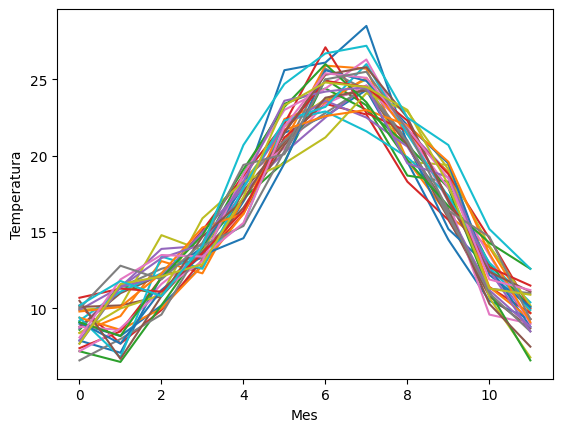

In [11]:
for year in range(1993,2023):
    plt.plot(df_temperaturas_30['Temperatura'].loc[df_temperaturas_30['Any']==year].to_numpy())
plt.xlabel('Mes')
plt.ylabel('Temperatura')
plt.show()

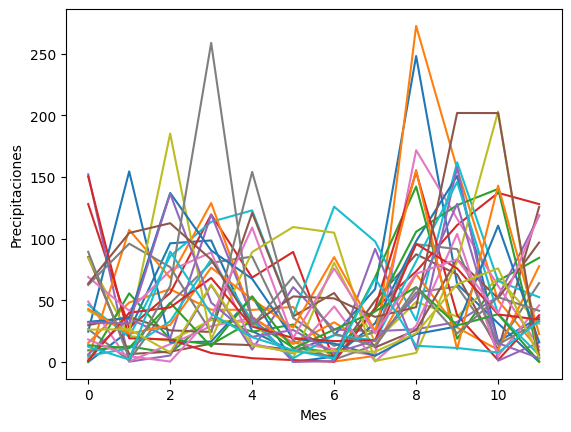

In [12]:
for year in range(1993,2023):
    plt.plot(df_lluvias_30['Precipitacions'].loc[df_lluvias_30['Any']==year].to_numpy())
plt.xlabel('Mes')
plt.ylabel('Precipitaciones')
plt.show()

# Estudio de los dataset con geocalización

Vista la escasa capacidad de predicir correctamente las predicipitaciones, vamos a enfocar nuestro proyecto en proporcionar información geolocalizada útil para las administraciones, con el objetivo que puedan desarrollar planes de acción para solventar las emergencias climáticas de las zonas más vunerables.

## Dataset de vegetación

Se dispone de dos datasets de información de la vegetación. Una que proporciona información de la cantidad de vegetación por zona y otra que proporciona información de la vulnerabilidad de la zona a las altas temperaturas.

In [13]:
pd.set_option('display.max_colwidth', None)
df_veg2017 = gpd.read_file("2017_vegetacio.gpkg")
df_veg2017

,PercNDVINo,geometry
0,-0.068700,"MULTIPOLYGON (((431304.850 4580691.507, 431258.357 4580616.224, 431282.447 4580602.204, 431270.577 4580582.424, 431673.785 4580334.660, 431676.505 4580331.140, 431676.745 4580326.571, 431674.915 4580321.540, 431597.954 4580196.801, 431594.064 4580195.891, 431590.874 4580196.111, 431578.794 4580202.381, 431227.008 4580418.035, 431226.509 4580420.118, 431167.116 4580456.152, 431161.940 4580460.303, 431162.290 4580471.537, 431125.032 4580494.750, 431064.090 4580532.721, 431059.486 4580536.080, 431125.674 4580641.645, 431025.787 4580676.273, 430860.963 4580693.984, 430820.709 4580698.090, 430839.980 4580751.545, 430854.770 4580799.715, 430884.986 4580881.099, 430889.560 4580894.594, 430896.780 4580915.894, 430930.123 4580945.708, 430944.502 4580960.985, 430960.396 4580978.860, 430971.892 4580994.583, 430990.304 4581024.837, 430996.791 4581035.240, 431023.008 4581075.868, 431044.104 4581101.894, 431045.501 4581099.759, 431046.902 4581102.380, 431058.471 4581119.632, 431076.902 4581077.309, 431078.800 4581072.860, 431097.638 4581028.715, 431167.942 4580903.954, 431223.274 4580822.833, 431217.326 4580813.808, 431214.776 4580808.215, 431214.071 4580806.199, 431213.264 4580803.351, 431212.631 4580800.456, 431212.176 4580797.530, 431211.911 4580794.741, 431211.782 4580793.174, 431211.745 4580791.433, 431211.819 4580789.692, 431211.998 4580787.960, 431212.287 4580786.241, 431212.679 4580784.547, 431213.179 4580782.875, 431213.780 4580781.239, 431214.480 4580779.648, 431215.354 4580777.953, 431216.304 4580776.529, 431217.251 4580775.295, 431218.275 4580774.125, 431219.376 4580773.023, 431222.604 4580770.192, 431209.080 4580748.459, 431304.334 4580691.814, 431304.850 4580691.507)))"
1,0.147311,"MULTIPOLYGON (((431050.990 4581133.590, 431058.471 4581119.632, 431046.902 4581102.380, 431045.501 4581099.759, 431044.104 4581101.894, 431023.008 4581075.868, 430996.791 4581035.240, 430990.304 4581024.837, 430971.892 4580994.583, 430960.396 4580978.860, 430944.502 4580960.985, 430930.123 4580945.708, 430896.780 4580915.894, 430889.560 4580894.594, 430778.978 4580924.645, 430766.186 4580934.851, 430990.550 4581216.105, 431023.546 4581164.327, 431050.990 4581133.590)))"
2,-0.365556,"MULTIPOLYGON (((430889.560 4580894.594, 430884.986 4580881.099, 430854.770 4580799.715, 430839.980 4580751.545, 430820.709 4580698.090, 430818.755 4580698.288, 430751.271 4580705.613, 430596.882 4580721.053, 430659.714 4580801.463, 430698.943 4580850.704, 430766.186 4580934.851, 430778.978 4580924.645, 430889.560 4580894.594)))"
3,0.050366,"MULTIPOLYGON (((430641.998 4581019.632, 430649.770 4581013.349, 430697.321 4580983.517, 430766.186 4580934.851, 430698.943 4580850.704, 430659.714 4580801.463, 430596.882 4580721.053, 430559.769 4580719.755, 430471.748 4580714.900, 430412.483 4580719.283, 430394.681 4580741.083, 430378.598 4580762.735, 430303.860 4580838.567, 430267.574 4580877.733, 430319.714 4580938.530, 430332.415 4580954.761, 430416.979 4580887.823, 430447.619 4580934.844, 430459.227 4580926.355, 430535.443 4580997.578, 430497.124 4581035.611, 430564.264 4581104.299, 430631.318 4581028.266, 430641.998 4581019.632)))"
4,-0.590935,"MULTIPOLYGON (((430938.474 4581297.493, 430945.572 4581286.688, 430990.550 4581216.105, 430766.186 4580934.851, 430697.321 4580983.517, 430649.770 4581013.349, 430641.998 4581019.632, 430687.036 4581072.471, 430726.827 4581119.936, 430767.401 4581166.661, 430784.772 4581189.377, 430803.197 4581216.377, 430817.249 4581239.656, 430825.263 4581255.315, 430836.580 4581279.268, 430846.232 4581306.750, 430873.298 4581396.711, 430938.474 4581297.493)))"
...,...,...
1056,1.599350,"MULTIPOLYGON (((433606.582 4585978.796, 433559.029 4585932.362, 433455.863 4586037.639, 433370.506 4586124.744, 433395.631 4586149.191, 433418.425 4586171.371, 433500.523 4586087.346, 433606.582 4585978.796)))"
1057,1.934771,"MULTIPOLYGON (((433832.353 4586030.956, 433761.035 4585960.739, 433775.301 4585945.575, 433750.767 4585922.351, 

In [15]:
df_veg2015 = gpd.read_file("2015_vulnera_faltaverd.gpkg")
df_veg2015

,ndviOn,geometry
0,4,"MULTIPOLYGON (((431304.850 4580691.507, 431258.357 4580616.224, 431282.447 4580602.204, 431270.577 4580582.424, 431673.785 4580334.660, 431676.505 4580331.140, 431676.745 4580326.571, 431674.915 4580321.540, 431597.954 4580196.801, 431594.064 4580195.891, 431590.874 4580196.111, 431578.794 4580202.381, 431227.008 4580418.035, 431226.509 4580420.118, 431167.116 4580456.152, 431161.940 4580460.303, 431162.290 4580471.537, 431125.032 4580494.750, 431064.090 4580532.721, 431059.486 4580536.080, 431125.674 4580641.645, 431025.787 4580676.273, 430860.963 4580693.984, 430820.709 4580698.090, 430839.980 4580751.545, 430854.770 4580799.715, 430884.986 4580881.099, 430889.560 4580894.594, 430896.780 4580915.894, 430930.123 4580945.708, 430944.502 4580960.985, 430960.396 4580978.860, 430971.892 4580994.583, 430990.304 4581024.837, 430996.791 4581035.240, 431023.008 4581075.868, 431044.104 4581101.894, 431045.501 4581099.759, 431046.902 4581102.380, 431058.471 4581119.632, 431076.902 4581077.309, 431078.800 4581072.860, 431097.638 4581028.715, 431167.942 4580903.954, 431223.274 4580822.833, 431217.326 4580813.808, 431214.776 4580808.215, 431214.071 4580806.199, 431213.264 4580803.351, 431212.631 4580800.456, 431212.176 4580797.530, 431211.911 4580794.741, 431211.782 4580793.174, 431211.745 4580791.433, 431211.819 4580789.692, 431211.998 4580787.960, 431212.287 4580786.241, 431212.679 4580784.547, 431213.179 4580782.875, 431213.780 4580781.239, 431214.480 4580779.648, 431215.354 4580777.953, 431216.304 4580776.529, 431217.251 4580775.295, 431218.275 4580774.125, 431219.376 4580773.023, 431222.604 4580770.192, 431209.080 4580748.459, 431304.334 4580691.814, 431304.850 4580691.507)))"
1,4,"MULTIPOLYGON (((431050.990 4581133.590, 431058.471 4581119.632, 431046.902 4581102.380, 431045.501 4581099.759, 431044.104 4581101.894, 431023.008 4581075.868, 430996.791 4581035.240, 430990.304 4581024.837, 430971.892 4580994.583, 430960.396 4580978.860, 430944.502 4580960.985, 430930.123 4580945.708, 430896.780 4580915.894, 430889.560 4580894.594, 430778.978 4580924.645, 430766.186 4580934.851, 430990.550 4581216.105, 431023.546 4581164.327, 431050.990 4581133.590)))"
2,5,"MULTIPOLYGON (((430889.560 4580894.594, 430884.986 4580881.099, 430854.770 4580799.715, 430839.980 4580751.545, 430820.709 4580698.090, 430818.755 4580698.288, 430751.271 4580705.613, 430596.882 4580721.053, 430659.714 4580801.463, 430698.943 4580850.704, 430766.186 4580934.851, 430778.978 4580924.645, 430889.560 4580894.594)))"
3,5,"MULTIPOLYGON (((430641.998 4581019.632, 430649.770 4581013.349, 430697.321 4580983.517, 430766.186 4580934.851, 430698.943 4580850.704, 430659.714 4580801.463, 430596.882 4580721.053, 430559.769 4580719.755, 430471.748 4580714.900, 430412.483 4580719.283, 430394.681 4580741.083, 430378.598 4580762.735, 430303.860 4580838.567, 430267.574 4580877.733, 430319.714 4580938.530, 430332.415 4580954.761, 430416.979 4580887.823, 430447.619 4580934.844, 430459.227 4580926.355, 430535.443 4580997.578, 430497.124 4581035.611, 430564.264 4581104.299, 430631.318 4581028.266, 430641.998 4581019.632)))"
4,6,"MULTIPOLYGON (((430938.474 4581297.493, 430945.572 4581286.688, 430990.550 4581216.105, 430766.186 4580934.851, 430697.321 4580983.517, 430649.770 4581013.349, 430641.998 4581019.632, 430687.036 4581072.471, 430726.827 4581119.936, 430767.401 4581166.661, 430784.772 4581189.377, 430803.197 4581216.377, 430817.249 4581239.656, 430825.263 4581255.315, 430836.580 4581279.268, 430846.232 4581306.750, 430873.298 4581396.711, 430938.474 4581297.493)))"
...,...,...
1056,4,"MULTIPOLYGON (((433606.582 4585978.796, 433559.029 4585932.362, 433455.863 4586037.639, 433370.506 4586124.744, 433395.631 4586149.191, 433418.425 4586171.371, 433500.523 4586087.346, 433606.582 4585978.796)))"
1057,4,"MULTIPOLYGON (((433832.353 4586030.956, 433761.035 4585960.739, 433775.301 4585945.575, 433750.767 4585922.351, 433709.188 4585882.991, 433656.224 4585832.853, 433559.0

Combinamos ambos datasets con los mismos registros de información de áreas urbanas.

In [16]:
df_comb=df_veg2015.copy()
df_comb.insert(0,'PercNDVINo',df_veg2017['PercNDVINo'])
df_comb

,PercNDVINo,ndviOn,geometry
0,-0.068700,4,"MULTIPOLYGON (((431304.850 4580691.507, 431258.357 4580616.224, 431282.447 4580602.204, 431270.577 4580582.424, 431673.785 4580334.660, 431676.505 4580331.140, 431676.745 4580326.571, 431674.915 4580321.540, 431597.954 4580196.801, 431594.064 4580195.891, 431590.874 4580196.111, 431578.794 4580202.381, 431227.008 4580418.035, 431226.509 4580420.118, 431167.116 4580456.152, 431161.940 4580460.303, 431162.290 4580471.537, 431125.032 4580494.750, 431064.090 4580532.721, 431059.486 4580536.080, 431125.674 4580641.645, 431025.787 4580676.273, 430860.963 4580693.984, 430820.709 4580698.090, 430839.980 4580751.545, 430854.770 4580799.715, 430884.986 4580881.099, 430889.560 4580894.594, 430896.780 4580915.894, 430930.123 4580945.708, 430944.502 4580960.985, 430960.396 4580978.860, 430971.892 4580994.583, 430990.304 4581024.837, 430996.791 4581035.240, 431023.008 4581075.868, 431044.104 4581101.894, 431045.501 4581099.759, 431046.902 4581102.380, 431058.471 4581119.632, 431076.902 4581077.309, 431078.800 4581072.860, 431097.638 4581028.715, 431167.942 4580903.954, 431223.274 4580822.833, 431217.326 4580813.808, 431214.776 4580808.215, 431214.071 4580806.199, 431213.264 4580803.351, 431212.631 4580800.456, 431212.176 4580797.530, 431211.911 4580794.741, 431211.782 4580793.174, 431211.745 4580791.433, 431211.819 4580789.692, 431211.998 4580787.960, 431212.287 4580786.241, 431212.679 4580784.547, 431213.179 4580782.875, 431213.780 4580781.239, 431214.480 4580779.648, 431215.354 4580777.953, 431216.304 4580776.529, 431217.251 4580775.295, 431218.275 4580774.125, 431219.376 4580773.023, 431222.604 4580770.192, 431209.080 4580748.459, 431304.334 4580691.814, 431304.850 4580691.507)))"
1,0.147311,4,"MULTIPOLYGON (((431050.990 4581133.590, 431058.471 4581119.632, 431046.902 4581102.380, 431045.501 4581099.759, 431044.104 4581101.894, 431023.008 4581075.868, 430996.791 4581035.240, 430990.304 4581024.837, 430971.892 4580994.583, 430960.396 4580978.860, 430944.502 4580960.985, 430930.123 4580945.708, 430896.780 4580915.894, 430889.560 4580894.594, 430778.978 4580924.645, 430766.186 4580934.851, 430990.550 4581216.105, 431023.546 4581164.327, 431050.990 4581133.590)))"
2,-0.365556,5,"MULTIPOLYGON (((430889.560 4580894.594, 430884.986 4580881.099, 430854.770 4580799.715, 430839.980 4580751.545, 430820.709 4580698.090, 430818.755 4580698.288, 430751.271 4580705.613, 430596.882 4580721.053, 430659.714 4580801.463, 430698.943 4580850.704, 430766.186 4580934.851, 430778.978 4580924.645, 430889.560 4580894.594)))"
3,0.050366,5,"MULTIPOLYGON (((430641.998 4581019.632, 430649.770 4581013.349, 430697.321 4580983.517, 430766.186 4580934.851, 430698.943 4580850.704, 430659.714 4580801.463, 430596.882 4580721.053, 430559.769 4580719.755, 430471.748 4580714.900, 430412.483 4580719.283, 430394.681 4580741.083, 430378.598 4580762.735, 430303.860 4580838.567, 430267.574 4580877.733, 430319.714 4580938.530, 430332.415 4580954.761, 430416.979 4580887.823, 430447.619 4580934.844, 430459.227 4580926.355, 430535.443 4580997.578, 430497.124 4581035.611, 430564.264 4581104.299, 430631.318 4581028.266, 430641.998 4581019.632)))"
4,-0.590935,6,"MULTIPOLYGON (((430938.474 4581297.493, 430945.572 4581286.688, 430990.550 4581216.105, 430766.186 4580934.851, 430697.321 4580983.517, 430649.770 4581013.349, 430641.998 4581019.632, 430687.036 4581072.471, 430726.827 4581119.936, 430767.401 4581166.661, 430784.772 4581189.377, 430803.197 4581216.377, 430817.249 4581239.656, 430825.263 4581255.315, 430836.580 4581279.268, 430846.232 4581306.750, 430873.298 4581396.711, 430938.474 4581297.493)))"
...,...,...,...
1056,1.599350,4,"MULTIPOLYGON (((433606.582 4585978.796, 433559.029 4585932.362, 433455.863 4586037.639, 433370.506 4586124.744, 433395.631 4586149.191, 433418.425 4586171.371, 433500.523 4586087.346, 433606.582 4585978.796)))"
1057,1.934771,4,"MULTIPOLYGON (((433832.353 4586030.956, 433761.035 4585960.739, 433775.301 4585945.575,

## Dataset de disposivos para el almacenamiento del agua

Disponemos de un dataset con información de los dispositivos de almacenamiento de agua. Dicho dataset no nos proporciona información sobre la capacidad de estos dispositivos, ni el volumen almacenado durante diferentes peridodos. No obstante, si nos proporciona información de su localización geográfica. En concreto, nos fijamos en las columnas geo_epgs_25831_x y geo_epgs_25831_y, quienes almacenan la información en el mismo formato que los datasets de vegetación. Nuestra primera intuición es que quizás la localización pueda estar correlacionada con las zonas de más vegetación o vunerabilidad observadas en el dataset previo, de forma que se puedan sugerir a los ayuntamientos de nuevas zonas donde construir nuevos dispositivos para mejorar la recogida de agua y las codiciones de la zona.

In [17]:
df_disp=pd.read_csv('dispotius.csv')
df_disp

,register_id,name,institution_id,institution_name,created,modified,addresses_roadtype_id,addresses_roadtype_name,addresses_road_id,addresses_road_name,...,secondary_filters_fullpath,secondary_filters_tree,secondary_filters_asia_id,geo_epgs_25831_x,geo_epgs_25831_y,geo_epgs_4326_x,geo_epgs_4326_y,estimated_dates,start_date,end_date
0,﻿99400167570,Dipòsit d'Aigües Pluvials Taulat,NaN,NaN,2006-09-18T14:08:28+02:00,2021-07-26T16:39:48.240711+02:00,NaN,NaN,332000,Carrer del Taulat,...,NaN,NaN,NaN,433199.478103,4.582913e+06,41.394979,2.200930,NaN,NaN,NaN
1,﻿99400034570,Dipòsit d'Aigües Pluvials Jardins dels Doctors Dolsa,NaN,NaN,2003-02-25T12:05:12+01:00,2021-07-26T16:37:41.869159+02:00,NaN,NaN,66508,Gran Via de Carles III,...,NaN,NaN,NaN,427120.746507,4.581383e+06,41.380675,2.128408,NaN,NaN,NaN
2,﻿99400073159,Dipòsit d'Aigües Pluvials Parc Joan Miró,NaN,NaN,2004-02-06T14:00:47+01:00,2021-07-26T16:39:23.165250+02:00,NaN,NaN,100800,Carrer de la Diputació,...,NaN,NaN,NaN,428734.686927,4.580855e+06,41.376063,2.147769,NaN,NaN,NaN
3,﻿99400035611,Dipòsit d'Aigües Pluvials Parc Central de Nou Barris,NaN,NaN,2003-03-13T10:29:43+01:00,2021-07-26T16:37:55.821521+02:00,NaN,NaN,363503,Carrer de Vilalba dels Arcs,...,NaN,NaN,NaN,430398.692368,4.587521e+06,41.436244,2.166900,NaN,NaN,NaN
4,﻿70162132,Dipòsit d'Aigües Pluvials Bori i Fontestà,NaN,NaN,2000-03-10T00:00:00+01:00,2023-02-15T13:28:51.128555+01:00,NaN,NaN,46103,Bori i Fontestà,...,NaN,NaN,NaN,427876.717857,4.582781e+06,41.393334,2.137281,NaN,NaN,NaN
5,﻿99400323050,Dipòsit d'Aigües Pluvials Parc de les Rieres d'Horta,NaN,NaN,2013-07-30T10:42:59+02:00,2021-07-26T16:38:41.303548+02:00,NaN,NaN,700651,Avinguda de l'Estatut de Catalunya,...,NaN,NaN,NaN,429342.403963,4.587055e+06,41.431952,2.154312,NaN,NaN,NaN
6,﻿99400257485,Dipòsit d'aigües pluvials Urgell/Mallorca,NaN,NaN,2010-10-14T13:17:01+02:00,2021-07-26T16:40:04.769025+02:00,NaN,NaN,349706,Carrer del Comte d'Urgell,...,NaN,NaN,NaN,429203.163141,4.581953e+06,41.385992,2.153243,NaN,NaN,NaN
7,﻿99400610786,Dipòsit d'Aigües Pluvials Parc del Poblenou,NaN,NaN,2018-10-10T14:33:38+02:00,2021-07-26T16:38:55.910191+02:00,NaN,NaN,700654,Avinguda del Litoral,...,NaN,NaN,NaN,433811.330119,4.583102e+06,41.396735,2.208227,NaN,NaN,NaN
8,﻿99400610787,Dipòsit d'Aigües Pluvials Parc Diagonal Mar,NaN,NaN,2018-10-10T14:36:23+02:00,2021-07-26T16:39:11.090237+02:00,NaN,NaN,186703,Carrer de Llull,...,NaN,NaN,NaN,434252.654558,4.584497e+06,41.409330,2.213355,NaN,NaN,NaN
9,﻿99050094556,Dipòsit d'Aigües Pluvials Escola Industrial,NaN,NaN,1999-02-19T00:00:00+01:00,2021-07-26T16:33:30.861622+02:00,NaN,NaN,361406,Carrer de Viladomat,...,NaN,NaN,NaN,428728.419103,4.582095e+06,41.387224,2.147549,NaN,NaN,NaN


Con el objetivo de estudiar esta posible correlación, vamos a calcular los centroides de los multipóligonos que conforman el área de las diferentes zonas geográficas de Barcelona.

In [19]:
#Coordenadas de los centroides de las áreas del dataset de vegetación
coord_poly = [ np.array((geom.xy[0][0], geom.xy[1][0])) for geom in df_comb.geometry.centroid ]
coord_poly=np.array(coord_poly)
coord_poly

array([[ 431199.85214735, 4580638.33736282],
       [ 430922.11317097, 4581039.38729206],
       [ 430760.57153654, 4580803.5299416 ],
       ...,
       [ 433806.63809757, 4585779.77639671],
       [ 433920.75249814, 4585914.38083597],
       [ 433906.63156995, 4586108.36187884]])

In [20]:
#Coordenadas de los dispositivos de agua
coord_disp=np.array(df_disp[['geo_epgs_25831_x','geo_epgs_25831_y']])
coord_disp

array([[ 433199.47810255, 4582913.00532626],
       [ 427120.74650694, 4581383.47799547],
       [ 428734.68692737, 4580855.34349462],
       [ 430398.69236804, 4587521.04383925],
       [ 427876.71785741, 4582781.38051696],
       [ 429342.40396289, 4587054.6709863 ],
       [ 429203.16314085, 4581953.17087824],
       [ 433811.33011925, 4583102.34259951],
       [ 434252.65455823, 4584496.7730857 ],
       [ 428728.4191028 , 4582094.58158769],
       [ 435005.92832708, 4584572.19481131],
       [ 424751.67687062, 4584856.43396889],
       [ 426114.97624043, 4581588.3357778 ]])

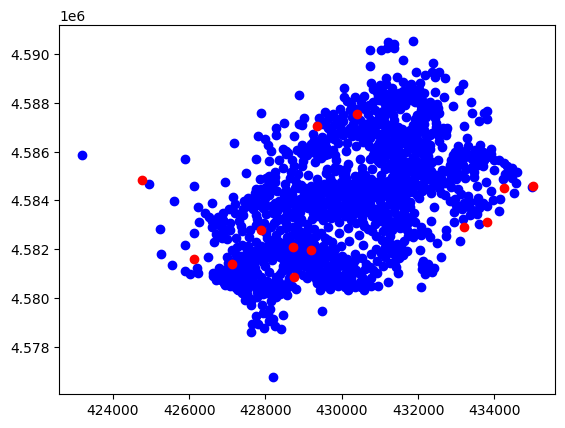

In [22]:
#Distribución de los dispositivos (rojo) y los centroides de cada area de con registros de vegetación (azul)
plt.scatter(coord_poly[:,0], coord_poly[:,1], c ="blue")
plt.scatter(coord_disp[:,0], coord_disp[:,1], c ="red") 
plt.show()

Como se puede observar, los dispositivos no están bien distribuidos por Barcelona, debido a que parecen concentrarse en zonas de mayor vegetación (Montjuïc, Collserola, etc) y mayor facilidad para acoger dichas infraestructuras (evitando por ejemplo el centro y la afluencia de líneas de metro y ferroviarias).

Para analizar si la proximidad de estos dispositivos afecta a las variables relacionadas con la vegetación, vamos a crear un modelo Kmeans cuyos centroides estén ubicados en la localización de estos dispositivos, para a posteriori calcular que áreas de vegetación se encuentran más proximas a cada uno de ellos.

In [23]:
kmeans = KMeans(n_clusters=len(coord_disp), random_state=0, n_init="auto").fit(coord_disp)
cluster_poly=kmeans.predict(coord_poly)
cluster_poly

array([12, 12, 12, ..., 10, 10, 10], dtype=int32)

In [24]:
#Calculamos la distancia máxima de cada área de vegetación con su dispositivo más cercano
N_poly=len(coord_poly)
dist_poly_disp=np.zeros(N_poly)
for i in range(N_poly):
    diffX=np.abs(coord_poly[i,0]-coord_disp[cluster_poly[i],0])
    diffY=np.abs(coord_poly[i,1]-coord_disp[cluster_poly[i],1])
    dist_poly_disp[i]=diffX+diffY
dist_poly_disp

array([6034.8743219 , 5356.08541628, 5430.40113231, ..., 2406.87181491,
       2427.3618536 , 2635.46382466])

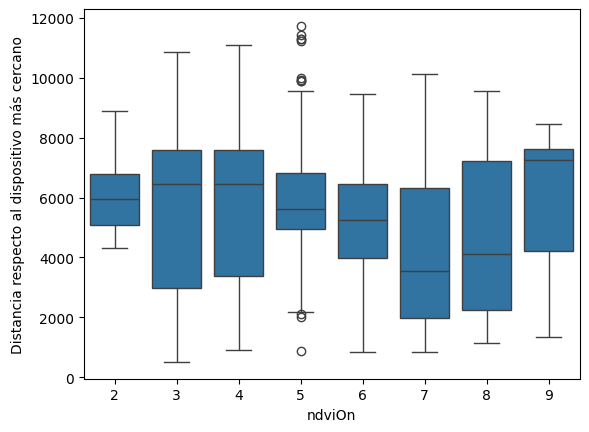

In [27]:
sns.boxplot(x=df_comb['ndviOn'], y=dist_poly_disp)
plt.ylabel('Distancia respecto al dispositivo más cercano')
plt.show()

En terminos de vulnerabilidad, no vemos que la distancia respecto al dispositivo más cercano afecte a esta variable.

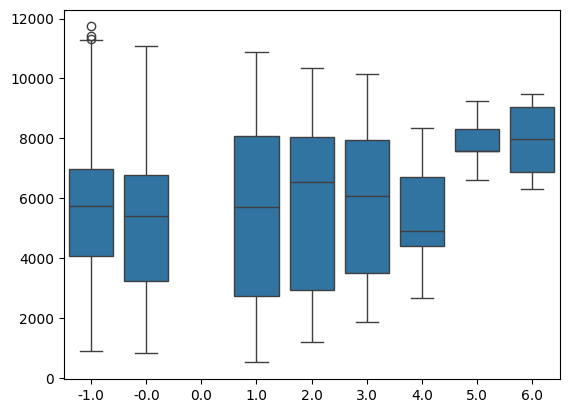

In [29]:
round_perc=np.array(np.round(df_comb['PercNDVINo'])) # Redondeamos para visualizar por rangos de grado de vegetación
sns.boxplot(x=round_perc, y=dist_poly_disp)
plt.show()

Lo mismo ocurre en terminos de nivel de vegetación en la zona. Por lo que concluimos que la información de los dispositivos no nos proporciona información de utilidad. Quizás si contaramos con información de volumenes almacenados o una relación de como su creciente construcción a podido contribuir a las áreas de vegetación de la ciudad, podríamos proporcionar información útil a las administraciones para considerar invertir en nuevas instalaciones y sus posibles localizaciones.

## Indice de actuación

La única relación observada entre las variables geográficas es la existente entre la variable que mide la cantidad de vegetación con las zonas vulnerables a altas temperaturas. Siendo la relación, mostrada en la siguiente figura, que cuanta mayor cantidad de vegetación existe en una zona, menos vulnerable es esta al calor, y cuanto más vulnerable es, menos vegetación existe.

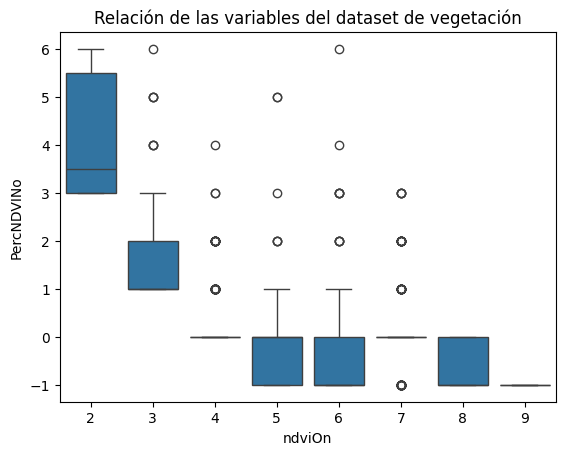

In [33]:
sns.boxplot(x=df_comb['ndviOn'], y=round_perc)
plt.ylabel('PercNDVINo')
plt.title('Relación de las variables del dataset de vegetación')
plt.show()

De cara a crear un indice de actuación, cuyo valor sea más alto en función de la necesidad de actuar en la zona por parte de las administraciones, se ha decidido crear una nueva variable que combine ambas variables de los datasets de vegetación.

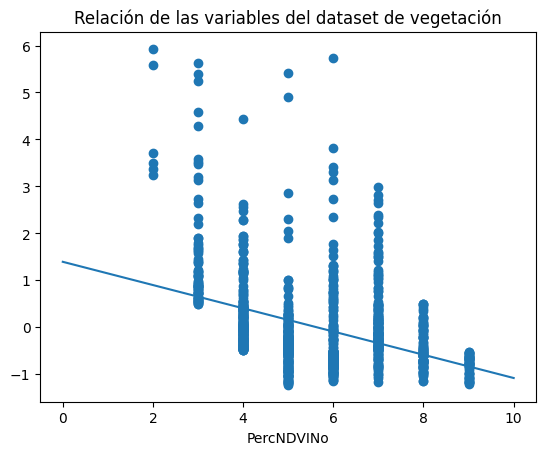

 
-0.2475 x + 1.394


In [45]:
#model = np.poly1d(np.polyfit(np.log(df_comb['ndviOn']), df_comb['PercNDVINo'], 1))
model = np.poly1d(np.polyfit(df_comb['ndviOn'], df_comb['PercNDVINo'], 1))

polyline = np.linspace(0, 10, 100) 
plt.scatter(df_comb['ndviOn'],df_comb['PercNDVINo']) 
plt.plot(polyline, model(polyline))
plt.xlabel('ndviOn')
plt.xlabel('PercNDVINo')
plt.title('Relación de las variables del dataset de vegetación')
plt.show() 
  
print(model) 

Si bien una regresión logarítmica parecía encajar mejor con la relación de los puntos de ambas variables, esta intuición no fue respaldada por los resultados obtenidos, razón por la cual nos decantamos finalmente por una regresión lineal que si bien tenía en menor consideración la relación de las variables en caso de alta vegetación, se alineaba mejor con el comportamiento de la nube de puntos.

In [47]:
act_index=model[1]*df_comb['ndviOn'] + model[0]

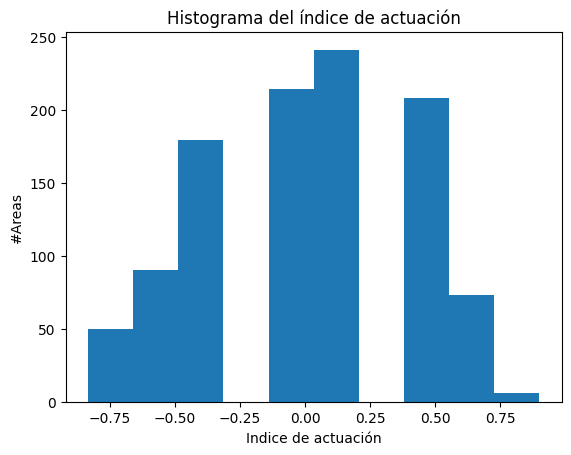

In [49]:
plt.hist(act_index)
plt.xlabel('Indice de actuación')
plt.ylabel('#Areas')
plt.title('Histograma del índice de actuación')
plt.show()

El índice de actuación resultante nos indica con valores entre 1 y -1, que zonas necesitan con emergencia actuación por parte de las administraciones (valores cercanos a 1) y cuales podemos considerar completamente protegidas (valores cercanos a -1).

In [50]:
df_comb.insert(0,'ActuacionIndex',act_index)
df_comb

,ActuacionIndex,PercNDVINo,ndviOn,geometry
0,0.403746,-0.068700,4,"MULTIPOLYGON (((431304.850 4580691.507, 431258.357 4580616.224, 431282.447 4580602.204, 431270.577 4580582.424, 431673.785 4580334.660, 431676.505 4580331.140, 431676.745 4580326.571, 431674.915 4580321.540, 431597.954 4580196.801, 431594.064 4580195.891, 431590.874 4580196.111, 431578.794 4580202.381, 431227.008 4580418.035, 431226.509 4580420.118, 431167.116 4580456.152, 431161.940 4580460.303, 431162.290 4580471.537, 431125.032 4580494.750, 431064.090 4580532.721, 431059.486 4580536.080, 431125.674 4580641.645, 431025.787 4580676.273, 430860.963 4580693.984, 430820.709 4580698.090, 430839.980 4580751.545, 430854.770 4580799.715, 430884.986 4580881.099, 430889.560 4580894.594, 430896.780 4580915.894, 430930.123 4580945.708, 430944.502 4580960.985, 430960.396 4580978.860, 430971.892 4580994.583, 430990.304 4581024.837, 430996.791 4581035.240, 431023.008 4581075.868, 431044.104 4581101.894, 431045.501 4581099.759, 431046.902 4581102.380, 431058.471 4581119.632, 431076.902 4581077.309, 431078.800 4581072.860, 431097.638 4581028.715, 431167.942 4580903.954, 431223.274 4580822.833, 431217.326 4580813.808, 431214.776 4580808.215, 431214.071 4580806.199, 431213.264 4580803.351, 431212.631 4580800.456, 431212.176 4580797.530, 431211.911 4580794.741, 431211.782 4580793.174, 431211.745 4580791.433, 431211.819 4580789.692, 431211.998 4580787.960, 431212.287 4580786.241, 431212.679 4580784.547, 431213.179 4580782.875, 431213.780 4580781.239, 431214.480 4580779.648, 431215.354 4580777.953, 431216.304 4580776.529, 431217.251 4580775.295, 431218.275 4580774.125, 431219.376 4580773.023, 431222.604 4580770.192, 431209.080 4580748.459, 431304.334 4580691.814, 431304.850 4580691.507)))"
1,0.403746,0.147311,4,"MULTIPOLYGON (((431050.990 4581133.590, 431058.471 4581119.632, 431046.902 4581102.380, 431045.501 4581099.759, 431044.104 4581101.894, 431023.008 4581075.868, 430996.791 4581035.240, 430990.304 4581024.837, 430971.892 4580994.583, 430960.396 4580978.860, 430944.502 4580960.985, 430930.123 4580945.708, 430896.780 4580915.894, 430889.560 4580894.594, 430778.978 4580924.645, 430766.186 4580934.851, 430990.550 4581216.105, 431023.546 4581164.327, 431050.990 4581133.590)))"
2,0.156274,-0.365556,5,"MULTIPOLYGON (((430889.560 4580894.594, 430884.986 4580881.099, 430854.770 4580799.715, 430839.980 4580751.545, 430820.709 4580698.090, 430818.755 4580698.288, 430751.271 4580705.613, 430596.882 4580721.053, 430659.714 4580801.463, 430698.943 4580850.704, 430766.186 4580934.851, 430778.978 4580924.645, 430889.560 4580894.594)))"
3,0.156274,0.050366,5,"MULTIPOLYGON (((430641.998 4581019.632, 430649.770 4581013.349, 430697.321 4580983.517, 430766.186 4580934.851, 430698.943 4580850.704, 430659.714 4580801.463, 430596.882 4580721.053, 430559.769 4580719.755, 430471.748 4580714.900, 430412.483 4580719.283, 430394.681 4580741.083, 430378.598 4580762.735, 430303.860 4580838.567, 430267.574 4580877.733, 430319.714 4580938.530, 430332.415 4580954.761, 430416.979 4580887.823, 430447.619 4580934.844, 430459.227 4580926.355, 430535.443 4580997.578, 430497.124 4581035.611, 430564.264 4581104.299, 430631.318 4581028.266, 430641.998 4581019.632)))"
4,-0.091199,-0.590935,6,"MULTIPOLYGON (((430938.474 4581297.493, 430945.572 4581286.688, 430990.550 4581216.105, 430766.186 4580934.851, 430697.321 4580983.517, 430649.770 4581013.349, 430641.998 4581019.632, 430687.036 4581072.471, 430726.827 4581119.936, 430767.401 4581166.661, 430784.772 4581189.377, 430803.197 4581216.377, 430817.249 4581239.656, 430825.263 4581255.315, 430836.580 4581279.268, 430846.232 4581306.750, 430873.298 4581396.711, 430938.474 4581297.493)))"
...,...,...,...,...
1056,0.403746,1.599350,4,"MULTIPOLYGON (((433606.582 4585978.796, 433559.029 4585932.362, 433455.863 4586037.639, 433370.506 4586124.744, 433395.631 4586149.191, 433418.425 4586171.371, 433500.523 4586087.346, 433606.582 4585978.796)))"
1057,0.403746,1.934771,4,"MULT

Este indice de actuación será el indicador principal para nuestro servicio de alerta administrativa.

In [52]:
df_comb.to_csv('data_act_index.csv', index=False)